In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
# Define the LEMCell
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out


In [3]:
from math import pi
v = 1/40
eta = 1/(2*v) - np.sqrt(1/(4*v*v) + 4*pi*pi)
x = np.linspace(-0.5, 1, 100)
y = np.linspace(-0.5, 0.5, 256)
X, Y = np.meshgrid(x, y)
u = 1 - np.exp(eta*X)*np.cos(2*pi*Y)
v = eta/(2*pi) * np.exp(eta*X)*np.sin(2*pi*Y)
vel = np.sqrt(u**2 + v**2)
p = 0.5*(1-np.exp(2*eta*X))

### PINN data importing

In [4]:
# importing data

# Load the .mat file
# mat_data = scipy.io.loadmat('cylinder_vorticity.mat')

# # Access the variables stored in the .mat file
# # The variable names in the .mat file become keys in the loaded dictionary
# x = mat_data['XX']
# t = mat_data['YY']
# u = mat_data['WW']

vel.shape

(256, 100)

### Exact Solution data importing

89

In [6]:
# # importing data

# import torch
# import torch.nn as nn
# import numpy as np
# import time
# import scipy.io

# # Load the .mat file
# mat_data = scipy.io.loadmat('burgers_shock.mat')

# # Access the variables stored in the .mat file
# # The variable names in the .mat file become keys in the loaded dictionary
# x = mat_data['x']
# t = mat_data['t']
# u_1 = mat_data['usol']


In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 80
batch_size = 1
num_epochs = 50000

# Set random seed for reproducibility
torch.manual_seed(42)


In [8]:
input_data = vel[:, 0:80]
target_data = u[:, 1:81]

test_data = u[:, 80]
#test_target = u[:,80:100]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

test data shape (256,)
input data shape (256, 80)
Target data shape (256, 80)
input tensor shape torch.Size([1, 80, 256])
Target tensor shape torch.Size([1, 80, 256])


In [9]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()
target_tensor = torch.squeeze(target_tensor)

In [10]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.16f}')

Epoch: 10/50000, Loss: 1.4303940534591675
Epoch: 20/50000, Loss: 1.3582142591476440
Epoch: 30/50000, Loss: 1.2861149311065674
Epoch: 40/50000, Loss: 1.2162197828292847
Epoch: 50/50000, Loss: 1.1442416906356812
Epoch: 60/50000, Loss: 1.0741761922836304
Epoch: 70/50000, Loss: 1.0089190006256104
Epoch: 80/50000, Loss: 0.9486018419265747
Epoch: 90/50000, Loss: 0.8926985859870911
Epoch: 100/50000, Loss: 0.8406213521957397
Epoch: 110/50000, Loss: 0.7904902100563049
Epoch: 120/50000, Loss: 0.7406731843948364
Epoch: 130/50000, Loss: 0.6934918165206909
Epoch: 140/50000, Loss: 0.6473377943038940
Epoch: 150/50000, Loss: 0.6057660579681396
Epoch: 160/50000, Loss: 0.5673070549964905
Epoch: 170/50000, Loss: 0.5316084027290344
Epoch: 180/50000, Loss: 0.4980642795562744
Epoch: 190/50000, Loss: 0.4658810198307037
Epoch: 200/50000, Loss: 0.4353536665439606
Epoch: 210/50000, Loss: 0.4069256186485291
Epoch: 220/50000, Loss: 0.3805579245090485
Epoch: 230/50000, Loss: 0.3560998439788818
Epoch: 240/50000, Lo

Epoch: 2090/50000, Loss: 0.0024508174974471
Epoch: 2100/50000, Loss: 0.0024034224916250
Epoch: 2110/50000, Loss: 0.0023574833758175
Epoch: 2120/50000, Loss: 0.0023129351902753
Epoch: 2130/50000, Loss: 0.0022697157692164
Epoch: 2140/50000, Loss: 0.0022277652751654
Epoch: 2150/50000, Loss: 0.0021870271302760
Epoch: 2160/50000, Loss: 0.0021474477835000
Epoch: 2170/50000, Loss: 0.0021089771762490
Epoch: 2180/50000, Loss: 0.0020715668797493
Epoch: 2190/50000, Loss: 0.0020351731218398
Epoch: 2200/50000, Loss: 0.0019997530616820
Epoch: 2210/50000, Loss: 0.0019652675837278
Epoch: 2220/50000, Loss: 0.0019316794350743
Epoch: 2230/50000, Loss: 0.0018989525269717
Epoch: 2240/50000, Loss: 0.0018670528661460
Epoch: 2250/50000, Loss: 0.0018359484383836
Epoch: 2260/50000, Loss: 0.0018056075787172
Epoch: 2270/50000, Loss: 0.0017760001355782
Epoch: 2280/50000, Loss: 0.0017470978200436
Epoch: 2290/50000, Loss: 0.0017188707133755
Epoch: 2300/50000, Loss: 0.0016912833089009
Epoch: 2310/50000, Loss: 0.00166

Epoch: 4140/50000, Loss: 0.0000735625726520
Epoch: 4150/50000, Loss: 0.0000728229570086
Epoch: 4160/50000, Loss: 0.0000750506733311
Epoch: 4170/50000, Loss: 0.0000786013479228
Epoch: 4180/50000, Loss: 0.0000755076980568
Epoch: 4190/50000, Loss: 0.0000701254612068
Epoch: 4200/50000, Loss: 0.0000700536911609
Epoch: 4210/50000, Loss: 0.0000684230253682
Epoch: 4220/50000, Loss: 0.0000677130447002
Epoch: 4230/50000, Loss: 0.0000670128210913
Epoch: 4240/50000, Loss: 0.0000662928068778
Epoch: 4250/50000, Loss: 0.0000656008560327
Epoch: 4260/50000, Loss: 0.0000649242429063
Epoch: 4270/50000, Loss: 0.0000642661034362
Epoch: 4280/50000, Loss: 0.0000636151162325
Epoch: 4290/50000, Loss: 0.0000629787900834
Epoch: 4300/50000, Loss: 0.0000626144610578
Epoch: 4310/50000, Loss: 0.0000910628878046
Epoch: 4320/50000, Loss: 0.0000745728975744
Epoch: 4330/50000, Loss: 0.0000662220481900
Epoch: 4340/50000, Loss: 0.0000607533074799
Epoch: 4350/50000, Loss: 0.0000594509256189
Epoch: 4360/50000, Loss: 0.00005

Epoch: 6140/50000, Loss: 0.0000144817950058
Epoch: 6150/50000, Loss: 0.0000144408722917
Epoch: 6160/50000, Loss: 0.0000143761380968
Epoch: 6170/50000, Loss: 0.0000142323724504
Epoch: 6180/50000, Loss: 0.0000140711781569
Epoch: 6190/50000, Loss: 0.0000139618659887
Epoch: 6200/50000, Loss: 0.0000138648483698
Epoch: 6210/50000, Loss: 0.0000137634415296
Epoch: 6220/50000, Loss: 0.0000136664793899
Epoch: 6230/50000, Loss: 0.0000135695518111
Epoch: 6240/50000, Loss: 0.0000134735673782
Epoch: 6250/50000, Loss: 0.0000133782759804
Epoch: 6260/50000, Loss: 0.0000132836667035
Epoch: 6270/50000, Loss: 0.0000131896831590
Epoch: 6280/50000, Loss: 0.0000130962826006
Epoch: 6290/50000, Loss: 0.0000130035259645
Epoch: 6300/50000, Loss: 0.0000129113759613
Epoch: 6310/50000, Loss: 0.0000128198244056
Epoch: 6320/50000, Loss: 0.0000127288421936
Epoch: 6330/50000, Loss: 0.0000126386075863
Epoch: 6340/50000, Loss: 0.0000125577716972
Epoch: 6350/50000, Loss: 0.0000136197895699
Epoch: 6360/50000, Loss: 0.00007

Epoch: 8180/50000, Loss: 0.0000132989644044
Epoch: 8190/50000, Loss: 0.0000122913888845
Epoch: 8200/50000, Loss: 0.0000052962018344
Epoch: 8210/50000, Loss: 0.0000035911248233
Epoch: 8220/50000, Loss: 0.0000032827222185
Epoch: 8230/50000, Loss: 0.0000032095588267
Epoch: 8240/50000, Loss: 0.0000031734016375
Epoch: 8250/50000, Loss: 0.0000031371989735
Epoch: 8260/50000, Loss: 0.0000030958490242
Epoch: 8270/50000, Loss: 0.0000030600081118
Epoch: 8280/50000, Loss: 0.0000030347682696
Epoch: 8290/50000, Loss: 0.0000030112707918
Epoch: 8300/50000, Loss: 0.0000029871723655
Epoch: 8310/50000, Loss: 0.0000029640491448
Epoch: 8320/50000, Loss: 0.0000029409729905
Epoch: 8330/50000, Loss: 0.0000029181933314
Epoch: 8340/50000, Loss: 0.0000028956146707
Epoch: 8350/50000, Loss: 0.0000028732526971
Epoch: 8360/50000, Loss: 0.0000028510423817
Epoch: 8370/50000, Loss: 0.0000028290037335
Epoch: 8380/50000, Loss: 0.0000028071181077
Epoch: 8390/50000, Loss: 0.0000027853802749
Epoch: 8400/50000, Loss: 0.00000

Epoch: 10140/50000, Loss: 0.0000009909858818
Epoch: 10150/50000, Loss: 0.0000009863923651
Epoch: 10160/50000, Loss: 0.0000009813646784
Epoch: 10170/50000, Loss: 0.0000009768457403
Epoch: 10180/50000, Loss: 0.0000009723437415
Epoch: 10190/50000, Loss: 0.0000009679728237
Epoch: 10200/50000, Loss: 0.0000009636964933
Epoch: 10210/50000, Loss: 0.0000009594607491
Epoch: 10220/50000, Loss: 0.0000009553029940
Epoch: 10230/50000, Loss: 0.0000009511935559
Epoch: 10240/50000, Loss: 0.0000009471517046
Epoch: 10250/50000, Loss: 0.0000009431499848
Epoch: 10260/50000, Loss: 0.0000009392035167
Epoch: 10270/50000, Loss: 0.0000009352626762
Epoch: 10280/50000, Loss: 0.0000009314261433
Epoch: 10290/50000, Loss: 0.0000009278654147
Epoch: 10300/50000, Loss: 0.0000009422171274
Epoch: 10310/50000, Loss: 0.0000033994315345
Epoch: 10320/50000, Loss: 0.0000372332215193
Epoch: 10330/50000, Loss: 0.0000165420970006
Epoch: 10340/50000, Loss: 0.0000055356526900
Epoch: 10350/50000, Loss: 0.0000021991377253
Epoch: 103

Epoch: 12010/50000, Loss: 0.0000006350113040
Epoch: 12020/50000, Loss: 0.0000006288199188
Epoch: 12030/50000, Loss: 0.0000006273974122
Epoch: 12040/50000, Loss: 0.0000006244380302
Epoch: 12050/50000, Loss: 0.0000006211008099
Epoch: 12060/50000, Loss: 0.0000006188164434
Epoch: 12070/50000, Loss: 0.0000006164954129
Epoch: 12080/50000, Loss: 0.0000006143069413
Epoch: 12090/50000, Loss: 0.0000006121768479
Epoch: 12100/50000, Loss: 0.0000006100873406
Epoch: 12110/50000, Loss: 0.0000006080432513
Epoch: 12120/50000, Loss: 0.0000006060633382
Epoch: 12130/50000, Loss: 0.0000006040891662
Epoch: 12140/50000, Loss: 0.0000006021497256
Epoch: 12150/50000, Loss: 0.0000006002359783
Epoch: 12160/50000, Loss: 0.0000005983603728
Epoch: 12170/50000, Loss: 0.0000005964735692
Epoch: 12180/50000, Loss: 0.0000005946146189
Epoch: 12190/50000, Loss: 0.0000005928107498
Epoch: 12200/50000, Loss: 0.0000005910389405
Epoch: 12210/50000, Loss: 0.0000005935152103
Epoch: 12220/50000, Loss: 0.0000013602615354
Epoch: 122

Epoch: 13850/50000, Loss: 0.0000004540868304
Epoch: 13860/50000, Loss: 0.0000004523062671
Epoch: 13870/50000, Loss: 0.0000004505656648
Epoch: 13880/50000, Loss: 0.0000004488510967
Epoch: 13890/50000, Loss: 0.0000004471776833
Epoch: 13900/50000, Loss: 0.0000004455485794
Epoch: 13910/50000, Loss: 0.0000004439355905
Epoch: 13920/50000, Loss: 0.0000004423353062
Epoch: 13930/50000, Loss: 0.0000004407590950
Epoch: 13940/50000, Loss: 0.0000004392196900
Epoch: 13950/50000, Loss: 0.0000004377036475
Epoch: 13960/50000, Loss: 0.0000004362102572
Epoch: 13970/50000, Loss: 0.0000004360142043
Epoch: 13980/50000, Loss: 0.0000005520808486
Epoch: 13990/50000, Loss: 0.0000201815091714
Epoch: 14000/50000, Loss: 0.0000275717648037
Epoch: 14010/50000, Loss: 0.0000062050557972
Epoch: 14020/50000, Loss: 0.0000024899945856
Epoch: 14030/50000, Loss: 0.0000011546694623
Epoch: 14040/50000, Loss: 0.0000006240481412
Epoch: 14050/50000, Loss: 0.0000004664977098
Epoch: 14060/50000, Loss: 0.0000004525581119
Epoch: 140

Epoch: 15900/50000, Loss: 0.0000003340575461
Epoch: 15910/50000, Loss: 0.0000003326296678
Epoch: 15920/50000, Loss: 0.0000003312551655
Epoch: 15930/50000, Loss: 0.0000003298838180
Epoch: 15940/50000, Loss: 0.0000003285570642
Epoch: 15950/50000, Loss: 0.0000003272697029
Epoch: 15960/50000, Loss: 0.0000003276936695
Epoch: 15970/50000, Loss: 0.0000005783209645
Epoch: 15980/50000, Loss: 0.0000505336320202
Epoch: 15990/50000, Loss: 0.0000109261982288
Epoch: 16000/50000, Loss: 0.0000024310243134
Epoch: 16010/50000, Loss: 0.0000003857417141
Epoch: 16020/50000, Loss: 0.0000005427323799
Epoch: 16030/50000, Loss: 0.0000005200726605
Epoch: 16040/50000, Loss: 0.0000004254613089
Epoch: 16050/50000, Loss: 0.0000003706118719
Epoch: 16060/50000, Loss: 0.0000003489531650
Epoch: 16070/50000, Loss: 0.0000003429451283
Epoch: 16080/50000, Loss: 0.0000003416799359
Epoch: 16090/50000, Loss: 0.0000003396982322
Epoch: 16100/50000, Loss: 0.0000003369885064
Epoch: 16110/50000, Loss: 0.0000003351022428
Epoch: 161

Epoch: 17770/50000, Loss: 0.0000003567349154
Epoch: 17780/50000, Loss: 0.0000229393262998
Epoch: 17790/50000, Loss: 0.0000341138220392
Epoch: 17800/50000, Loss: 0.0000114829681479
Epoch: 17810/50000, Loss: 0.0000031989470699
Epoch: 17820/50000, Loss: 0.0000006590481689
Epoch: 17830/50000, Loss: 0.0000003034204497
Epoch: 17840/50000, Loss: 0.0000002857218533
Epoch: 17850/50000, Loss: 0.0000002820013947
Epoch: 17860/50000, Loss: 0.0000002792281748
Epoch: 17870/50000, Loss: 0.0000002781506794
Epoch: 17880/50000, Loss: 0.0000002766610123
Epoch: 17890/50000, Loss: 0.0000002738351839
Epoch: 17900/50000, Loss: 0.0000002710912383
Epoch: 17910/50000, Loss: 0.0000002693766419
Epoch: 17920/50000, Loss: 0.0000002677722364
Epoch: 17930/50000, Loss: 0.0000002661885503
Epoch: 17940/50000, Loss: 0.0000002647151973
Epoch: 17950/50000, Loss: 0.0000002632838232
Epoch: 17960/50000, Loss: 0.0000002618868677
Epoch: 17970/50000, Loss: 0.0000002605435725
Epoch: 17980/50000, Loss: 0.0000002592200872
Epoch: 179

Epoch: 19790/50000, Loss: 0.0000002019757233
Epoch: 19800/50000, Loss: 0.0000002012406668
Epoch: 19810/50000, Loss: 0.0000002216835355
Epoch: 19820/50000, Loss: 0.0000054472866395
Epoch: 19830/50000, Loss: 0.0000013085327737
Epoch: 19840/50000, Loss: 0.0000013632291029
Epoch: 19850/50000, Loss: 0.0000039594588088
Epoch: 19860/50000, Loss: 0.0000014675208604
Epoch: 19870/50000, Loss: 0.0000002708524960
Epoch: 19880/50000, Loss: 0.0000002869582545
Epoch: 19890/50000, Loss: 0.0000002844385563
Epoch: 19900/50000, Loss: 0.0000002505293821
Epoch: 19910/50000, Loss: 0.0000002309157736
Epoch: 19920/50000, Loss: 0.0000002218054789
Epoch: 19930/50000, Loss: 0.0000002170309870
Epoch: 19940/50000, Loss: 0.0000002140490807
Epoch: 19950/50000, Loss: 0.0000002119839309
Epoch: 19960/50000, Loss: 0.0000002103261352
Epoch: 19970/50000, Loss: 0.0000002087757167
Epoch: 19980/50000, Loss: 0.0000002073371661
Epoch: 19990/50000, Loss: 0.0000002060026247
Epoch: 20000/50000, Loss: 0.0000002047388250
Epoch: 200

Epoch: 21830/50000, Loss: 0.0000001584584197
Epoch: 21840/50000, Loss: 0.0000001577237185
Epoch: 21850/50000, Loss: 0.0000001570460029
Epoch: 21860/50000, Loss: 0.0000001583974409
Epoch: 21870/50000, Loss: 0.0000004521213555
Epoch: 21880/50000, Loss: 0.0000457070964330
Epoch: 21890/50000, Loss: 0.0000006012986091
Epoch: 21900/50000, Loss: 0.0000033794669889
Epoch: 21910/50000, Loss: 0.0000019175502075
Epoch: 21920/50000, Loss: 0.0000002936049555
Epoch: 21930/50000, Loss: 0.0000002260671863
Epoch: 21940/50000, Loss: 0.0000002311049059
Epoch: 21950/50000, Loss: 0.0000002020547356
Epoch: 21960/50000, Loss: 0.0000001827320517
Epoch: 21970/50000, Loss: 0.0000001732838371
Epoch: 21980/50000, Loss: 0.0000001689668068
Epoch: 21990/50000, Loss: 0.0000001669179994
Epoch: 22000/50000, Loss: 0.0000001651689274
Epoch: 22010/50000, Loss: 0.0000001634125226
Epoch: 22020/50000, Loss: 0.0000001620237811
Epoch: 22030/50000, Loss: 0.0000001607408677
Epoch: 22040/50000, Loss: 0.0000001595824699
Epoch: 220

Epoch: 23690/50000, Loss: 0.0000001162001482
Epoch: 23700/50000, Loss: 0.0000001153840472
Epoch: 23710/50000, Loss: 0.0000001146033597
Epoch: 23720/50000, Loss: 0.0000001138583130
Epoch: 23730/50000, Loss: 0.0000001131329981
Epoch: 23740/50000, Loss: 0.0000001124341651
Epoch: 23750/50000, Loss: 0.0000001118504542
Epoch: 23760/50000, Loss: 0.0000001268037977
Epoch: 23770/50000, Loss: 0.0000053594822020
Epoch: 23780/50000, Loss: 0.0000137650658871
Epoch: 23790/50000, Loss: 0.0000086760974227
Epoch: 23800/50000, Loss: 0.0000015161476767
Epoch: 23810/50000, Loss: 0.0000001944823680
Epoch: 23820/50000, Loss: 0.0000003762115171
Epoch: 23830/50000, Loss: 0.0000002372195951
Epoch: 23840/50000, Loss: 0.0000001770993805
Epoch: 23850/50000, Loss: 0.0000001394875113
Epoch: 23860/50000, Loss: 0.0000001282087112
Epoch: 23870/50000, Loss: 0.0000001214522456
Epoch: 23880/50000, Loss: 0.0000001186140253
Epoch: 23890/50000, Loss: 0.0000001169740216
Epoch: 23900/50000, Loss: 0.0000001157781995
Epoch: 239

Epoch: 25530/50000, Loss: 0.0000000805449645
Epoch: 25540/50000, Loss: 0.0000000782399354
Epoch: 25550/50000, Loss: 0.0000000772797293
Epoch: 25560/50000, Loss: 0.0000000764796084
Epoch: 25570/50000, Loss: 0.0000000756775620
Epoch: 25580/50000, Loss: 0.0000000753985745
Epoch: 25590/50000, Loss: 0.0000000745647881
Epoch: 25600/50000, Loss: 0.0000000737277190
Epoch: 25610/50000, Loss: 0.0000000731462961
Epoch: 25620/50000, Loss: 0.0000000725635942
Epoch: 25630/50000, Loss: 0.0000000720431075
Epoch: 25640/50000, Loss: 0.0000000717332327
Epoch: 25650/50000, Loss: 0.0000000710494277
Epoch: 25660/50000, Loss: 0.0000000716003470
Epoch: 25670/50000, Loss: 0.0000001709619966
Epoch: 25680/50000, Loss: 0.0000156302830874
Epoch: 25690/50000, Loss: 0.0000102386320577
Epoch: 25700/50000, Loss: 0.0000037032859836
Epoch: 25710/50000, Loss: 0.0000016114987602
Epoch: 25720/50000, Loss: 0.0000005327274835
Epoch: 25730/50000, Loss: 0.0000001373746557
Epoch: 25740/50000, Loss: 0.0000000826211846
Epoch: 257

Epoch: 27390/50000, Loss: 0.0000251588116953
Epoch: 27400/50000, Loss: 0.0000014280793721
Epoch: 27410/50000, Loss: 0.0000003404358324
Epoch: 27420/50000, Loss: 0.0000007159393363
Epoch: 27430/50000, Loss: 0.0000003277999667
Epoch: 27440/50000, Loss: 0.0000000648602168
Epoch: 27450/50000, Loss: 0.0000000938168512
Epoch: 27460/50000, Loss: 0.0000000619654941
Epoch: 27470/50000, Loss: 0.0000000618506988
Epoch: 27480/50000, Loss: 0.0000000565739349
Epoch: 27490/50000, Loss: 0.0000000561697497
Epoch: 27500/50000, Loss: 0.0000000555081030
Epoch: 27510/50000, Loss: 0.0000000548337589
Epoch: 27520/50000, Loss: 0.0000000543052572
Epoch: 27530/50000, Loss: 0.0000000538489751
Epoch: 27540/50000, Loss: 0.0000000537022906
Epoch: 27550/50000, Loss: 0.0000000530794395
Epoch: 27560/50000, Loss: 0.0000000527519433
Epoch: 27570/50000, Loss: 0.0000000523169703
Epoch: 27580/50000, Loss: 0.0000000519999261
Epoch: 27590/50000, Loss: 0.0000000527777431
Epoch: 27600/50000, Loss: 0.0000001512822365
Epoch: 276

Epoch: 29370/50000, Loss: 0.0000002881436956
Epoch: 29380/50000, Loss: 0.0000000753186029
Epoch: 29390/50000, Loss: 0.0000000692817750
Epoch: 29400/50000, Loss: 0.0000000671727847
Epoch: 29410/50000, Loss: 0.0000000499408479
Epoch: 29420/50000, Loss: 0.0000000502089748
Epoch: 29430/50000, Loss: 0.0000000475628532
Epoch: 29440/50000, Loss: 0.0000000474177924
Epoch: 29450/50000, Loss: 0.0000000468844910
Epoch: 29460/50000, Loss: 0.0000000464669583
Epoch: 29470/50000, Loss: 0.0000000461422296
Epoch: 29480/50000, Loss: 0.0000000458386360
Epoch: 29490/50000, Loss: 0.0000000455542519
Epoch: 29500/50000, Loss: 0.0000000453350353
Epoch: 29510/50000, Loss: 0.0000000455709781
Epoch: 29520/50000, Loss: 0.0000000448069208
Epoch: 29530/50000, Loss: 0.0000000445596058
Epoch: 29540/50000, Loss: 0.0000000443163728
Epoch: 29550/50000, Loss: 0.0000000441791492
Epoch: 29560/50000, Loss: 0.0000000515469409
Epoch: 29570/50000, Loss: 0.0000011314989479
Epoch: 29580/50000, Loss: 0.0000109104130388
Epoch: 295

Epoch: 31380/50000, Loss: 0.0000000587179088
Epoch: 31390/50000, Loss: 0.0000000473265978
Epoch: 31400/50000, Loss: 0.0000000467344350
Epoch: 31410/50000, Loss: 0.0000000459085143
Epoch: 31420/50000, Loss: 0.0000000453661180
Epoch: 31430/50000, Loss: 0.0000000449635174
Epoch: 31440/50000, Loss: 0.0000000447050859
Epoch: 31450/50000, Loss: 0.0000000444435422
Epoch: 31460/50000, Loss: 0.0000000442003980
Epoch: 31470/50000, Loss: 0.0000000439674679
Epoch: 31480/50000, Loss: 0.0000000437526779
Epoch: 31490/50000, Loss: 0.0000000435344347
Epoch: 31500/50000, Loss: 0.0000000433256062
Epoch: 31510/50000, Loss: 0.0000000431176019
Epoch: 31520/50000, Loss: 0.0000000429186073
Epoch: 31530/50000, Loss: 0.0000000427233999
Epoch: 31540/50000, Loss: 0.0000000425368185
Epoch: 31550/50000, Loss: 0.0000000427337845
Epoch: 31560/50000, Loss: 0.0000000895210803
Epoch: 31570/50000, Loss: 0.0000095942987173
Epoch: 31580/50000, Loss: 0.0000097877691587
Epoch: 31590/50000, Loss: 0.0000020961695100
Epoch: 316

Epoch: 33430/50000, Loss: 0.0000000415405630
Epoch: 33440/50000, Loss: 0.0000000413506669
Epoch: 33450/50000, Loss: 0.0000000411642276
Epoch: 33460/50000, Loss: 0.0000000409830321
Epoch: 33470/50000, Loss: 0.0000000408051228
Epoch: 33480/50000, Loss: 0.0000000406365537
Epoch: 33490/50000, Loss: 0.0000000404665492
Epoch: 33500/50000, Loss: 0.0000000403337665
Epoch: 33510/50000, Loss: 0.0000000417486774
Epoch: 33520/50000, Loss: 0.0000002120782199
Epoch: 33530/50000, Loss: 0.0000189089714695
Epoch: 33540/50000, Loss: 0.0000012945005210
Epoch: 33550/50000, Loss: 0.0000007546358347
Epoch: 33560/50000, Loss: 0.0000001944992647
Epoch: 33570/50000, Loss: 0.0000000560529152
Epoch: 33580/50000, Loss: 0.0000000431576375
Epoch: 33590/50000, Loss: 0.0000000420455954
Epoch: 33600/50000, Loss: 0.0000000414003054
Epoch: 33610/50000, Loss: 0.0000000414187831
Epoch: 33620/50000, Loss: 0.0000000414442347
Epoch: 33630/50000, Loss: 0.0000000410139585
Epoch: 33640/50000, Loss: 0.0000000403953990
Epoch: 336

Epoch: 35460/50000, Loss: 0.0000000357764520
Epoch: 35470/50000, Loss: 0.0000000356953755
Epoch: 35480/50000, Loss: 0.0000000371254885
Epoch: 35490/50000, Loss: 0.0000002374277273
Epoch: 35500/50000, Loss: 0.0000080505351434
Epoch: 35510/50000, Loss: 0.0000040252753024
Epoch: 35520/50000, Loss: 0.0000014722024844
Epoch: 35530/50000, Loss: 0.0000002932544589
Epoch: 35540/50000, Loss: 0.0000002629656137
Epoch: 35550/50000, Loss: 0.0000000819652470
Epoch: 35560/50000, Loss: 0.0000000526888471
Epoch: 35570/50000, Loss: 0.0000000444017978
Epoch: 35580/50000, Loss: 0.0000000386236181
Epoch: 35590/50000, Loss: 0.0000000367205537
Epoch: 35600/50000, Loss: 0.0000000360827883
Epoch: 35610/50000, Loss: 0.0000000358636214
Epoch: 35620/50000, Loss: 0.0000000357816567
Epoch: 35630/50000, Loss: 0.0000000355661669
Epoch: 35640/50000, Loss: 0.0000000354619658
Epoch: 35650/50000, Loss: 0.0000000354168037
Epoch: 35660/50000, Loss: 0.0000000367284869
Epoch: 35670/50000, Loss: 0.0000001002359653
Epoch: 356

Epoch: 37300/50000, Loss: 0.0000000381479488
Epoch: 37310/50000, Loss: 0.0000000348143665
Epoch: 37320/50000, Loss: 0.0000000322975140
Epoch: 37330/50000, Loss: 0.0000000309917318
Epoch: 37340/50000, Loss: 0.0000000307817132
Epoch: 37350/50000, Loss: 0.0000000307231218
Epoch: 37360/50000, Loss: 0.0000000305749026
Epoch: 37370/50000, Loss: 0.0000000305494297
Epoch: 37380/50000, Loss: 0.0000000320032818
Epoch: 37390/50000, Loss: 0.0000001454711196
Epoch: 37400/50000, Loss: 0.0000088279803094
Epoch: 37410/50000, Loss: 0.0000036416872717
Epoch: 37420/50000, Loss: 0.0000000457612934
Epoch: 37430/50000, Loss: 0.0000004027620832
Epoch: 37440/50000, Loss: 0.0000000675079406
Epoch: 37450/50000, Loss: 0.0000000693616542
Epoch: 37460/50000, Loss: 0.0000000559992586
Epoch: 37470/50000, Loss: 0.0000000359199746
Epoch: 37480/50000, Loss: 0.0000000318175282
Epoch: 37490/50000, Loss: 0.0000000314925153
Epoch: 37500/50000, Loss: 0.0000000310645945
Epoch: 37510/50000, Loss: 0.0000000309649515
Epoch: 375

Epoch: 39340/50000, Loss: 0.0000000361508121
Epoch: 39350/50000, Loss: 0.0000008407220662
Epoch: 39360/50000, Loss: 0.0000063953884819
Epoch: 39370/50000, Loss: 0.0000018667130917
Epoch: 39380/50000, Loss: 0.0000003114518563
Epoch: 39390/50000, Loss: 0.0000001219660817
Epoch: 39400/50000, Loss: 0.0000001343151013
Epoch: 39410/50000, Loss: 0.0000000689096140
Epoch: 39420/50000, Loss: 0.0000000321494511
Epoch: 39430/50000, Loss: 0.0000000315072768
Epoch: 39440/50000, Loss: 0.0000000281822796
Epoch: 39450/50000, Loss: 0.0000000272683849
Epoch: 39460/50000, Loss: 0.0000000267773483
Epoch: 39470/50000, Loss: 0.0000000267441571
Epoch: 39480/50000, Loss: 0.0000000265772062
Epoch: 39490/50000, Loss: 0.0000000264603326
Epoch: 39500/50000, Loss: 0.0000000263756075
Epoch: 39510/50000, Loss: 0.0000000262958686
Epoch: 39520/50000, Loss: 0.0000000262242104
Epoch: 39530/50000, Loss: 0.0000000262748294
Epoch: 39540/50000, Loss: 0.0000000324092326
Epoch: 39550/50000, Loss: 0.0000006575919542
Epoch: 395

Epoch: 41170/50000, Loss: 0.0000000242373002
Epoch: 41180/50000, Loss: 0.0000000236831852
Epoch: 41190/50000, Loss: 0.0000000236238602
Epoch: 41200/50000, Loss: 0.0000000235393198
Epoch: 41210/50000, Loss: 0.0000000235149180
Epoch: 41220/50000, Loss: 0.0000000247543230
Epoch: 41230/50000, Loss: 0.0000000740254649
Epoch: 41240/50000, Loss: 0.0000031642025533
Epoch: 41250/50000, Loss: 0.0000020799564027
Epoch: 41260/50000, Loss: 0.0000000426028848
Epoch: 41270/50000, Loss: 0.0000002130907717
Epoch: 41280/50000, Loss: 0.0000001414448434
Epoch: 41290/50000, Loss: 0.0000000290685396
Epoch: 41300/50000, Loss: 0.0000000371459166
Epoch: 41310/50000, Loss: 0.0000000270207376
Epoch: 41320/50000, Loss: 0.0000000274490937
Epoch: 41330/50000, Loss: 0.0000000242260203
Epoch: 41340/50000, Loss: 0.0000000235744206
Epoch: 41350/50000, Loss: 0.0000000235502213
Epoch: 41360/50000, Loss: 0.0000000242376252
Epoch: 41370/50000, Loss: 0.0000000650265619
Epoch: 41380/50000, Loss: 0.0000037685360894
Epoch: 413

Epoch: 43210/50000, Loss: 0.0000001123289408
Epoch: 43220/50000, Loss: 0.0000002884882235
Epoch: 43230/50000, Loss: 0.0000002298942690
Epoch: 43240/50000, Loss: 0.0000000547688224
Epoch: 43250/50000, Loss: 0.0000000486696301
Epoch: 43260/50000, Loss: 0.0000000231475425
Epoch: 43270/50000, Loss: 0.0000000366416550
Epoch: 43280/50000, Loss: 0.0000001711728999
Epoch: 43290/50000, Loss: 0.0000028148240290
Epoch: 43300/50000, Loss: 0.0000001391824327
Epoch: 43310/50000, Loss: 0.0000002409387321
Epoch: 43320/50000, Loss: 0.0000001997208727
Epoch: 43330/50000, Loss: 0.0000001108473953
Epoch: 43340/50000, Loss: 0.0000000647472689
Epoch: 43350/50000, Loss: 0.0000000356315155
Epoch: 43360/50000, Loss: 0.0000000240498164
Epoch: 43370/50000, Loss: 0.0000000240058959
Epoch: 43380/50000, Loss: 0.0000000233779893
Epoch: 43390/50000, Loss: 0.0000000372363402
Epoch: 43400/50000, Loss: 0.0000005783994652
Epoch: 43410/50000, Loss: 0.0000042057808969
Epoch: 43420/50000, Loss: 0.0000004991576930
Epoch: 434

Epoch: 45080/50000, Loss: 0.0000003709331509
Epoch: 45090/50000, Loss: 0.0000001807408267
Epoch: 45100/50000, Loss: 0.0000000268605227
Epoch: 45110/50000, Loss: 0.0000000296251503
Epoch: 45120/50000, Loss: 0.0000000289462214
Epoch: 45130/50000, Loss: 0.0000000253273438
Epoch: 45140/50000, Loss: 0.0000000231518715
Epoch: 45150/50000, Loss: 0.0000000226472032
Epoch: 45160/50000, Loss: 0.0000000312579616
Epoch: 45170/50000, Loss: 0.0000004152758208
Epoch: 45180/50000, Loss: 0.0000033882329262
Epoch: 45190/50000, Loss: 0.0000001570533783
Epoch: 45200/50000, Loss: 0.0000003944069249
Epoch: 45210/50000, Loss: 0.0000001131712111
Epoch: 45220/50000, Loss: 0.0000000694869442
Epoch: 45230/50000, Loss: 0.0000000392770438
Epoch: 45240/50000, Loss: 0.0000000522946664
Epoch: 45250/50000, Loss: 0.0000001769534208
Epoch: 45260/50000, Loss: 0.0000020148759177
Epoch: 45270/50000, Loss: 0.0000000669281448
Epoch: 45280/50000, Loss: 0.0000000782047636
Epoch: 45290/50000, Loss: 0.0000000822245312
Epoch: 453

Epoch: 47130/50000, Loss: 0.0000000246975418
Epoch: 47140/50000, Loss: 0.0000000285967534
Epoch: 47150/50000, Loss: 0.0000000232083615
Epoch: 47160/50000, Loss: 0.0000000770825537
Epoch: 47170/50000, Loss: 0.0000032173543332
Epoch: 47180/50000, Loss: 0.0000029243294648
Epoch: 47190/50000, Loss: 0.0000001854870533
Epoch: 47200/50000, Loss: 0.0000001928964082
Epoch: 47210/50000, Loss: 0.0000001431842378
Epoch: 47220/50000, Loss: 0.0000000414937134
Epoch: 47230/50000, Loss: 0.0000000361953134
Epoch: 47240/50000, Loss: 0.0000000283219173
Epoch: 47250/50000, Loss: 0.0000001087050663
Epoch: 47260/50000, Loss: 0.0000031830616081
Epoch: 47270/50000, Loss: 0.0000009049485925
Epoch: 47280/50000, Loss: 0.0000009474409239
Epoch: 47290/50000, Loss: 0.0000001036915691
Epoch: 47300/50000, Loss: 0.0000000836188718
Epoch: 47310/50000, Loss: 0.0000000560812516
Epoch: 47320/50000, Loss: 0.0000000284595991
Epoch: 47330/50000, Loss: 0.0000000230896706
Epoch: 47340/50000, Loss: 0.0000000228378969
Epoch: 473

Epoch: 48970/50000, Loss: 0.0000004178506856
Epoch: 48980/50000, Loss: 0.0000000291969453
Epoch: 48990/50000, Loss: 0.0000000875829258
Epoch: 49000/50000, Loss: 0.0000000232190942
Epoch: 49010/50000, Loss: 0.0000000299958671
Epoch: 49020/50000, Loss: 0.0000000272936056
Epoch: 49030/50000, Loss: 0.0000001085680310
Epoch: 49040/50000, Loss: 0.0000028195199775
Epoch: 49050/50000, Loss: 0.0000011593106137
Epoch: 49060/50000, Loss: 0.0000001059086472
Epoch: 49070/50000, Loss: 0.0000001248188966
Epoch: 49080/50000, Loss: 0.0000000776229996
Epoch: 49090/50000, Loss: 0.0000000307479162
Epoch: 49100/50000, Loss: 0.0000000226629027
Epoch: 49110/50000, Loss: 0.0000000226556089
Epoch: 49120/50000, Loss: 0.0000000220927756
Epoch: 49130/50000, Loss: 0.0000000220914096
Epoch: 49140/50000, Loss: 0.0000000218836682
Epoch: 49150/50000, Loss: 0.0000000222989787
Epoch: 49160/50000, Loss: 0.0000000625263255
Epoch: 49170/50000, Loss: 0.0000043440327318
Epoch: 49180/50000, Loss: 0.0000042863298404
Epoch: 491

In [11]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 20, 256])


In [12]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        

### Four different types of error

In [36]:
# Exact Solution

u_test = u.T
u_test_full = u_test[80:100, :]

In [37]:
prediction_tensor = torch.squeeze(prediction_tensor)
prediction_tensor.shape

torch.Size([20, 256])

In [38]:
# Extrapolation

k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([20, 256])

### L^2 norm error

In [39]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item())

Relative Error Test:  0.0010257702330723959


### Max absolute norm error

In [41]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))

In [42]:
print(R_abs)

tensor(0.0906, dtype=torch.float64)


### Explained variance score

In [43]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
# a = torch.tensor(a)
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

Explained Variance Score: 0.9884500260975663


### Mean absolute error

In [44]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")

Relative Error Test:  tensor(0.0241, dtype=torch.float64) %


### Contour plot for PINN (80 percent) and (20 percentage lem prediction)

In [45]:
print(prediction_tensor.shape)
prediction_tensor = torch.squeeze(prediction_tensor)
input_tensor = torch.squeeze(input_tensor)

conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

x1 = np.linspace(-0.5, 1, 100)
t1 = np.linspace(-0.5, 0.5, 256)

torch.Size([20, 256])


### Snapshot time plots

ValueError: x and y must have same first dimension, but have shapes (100,) and (256, 1)

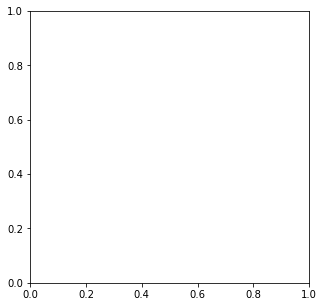

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

final_time_output = prediction_tensor[3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[83, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x1, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x1, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.83}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.83_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.83_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


ValueError: x and y must have same first dimension, but have shapes (100,) and (256, 1)

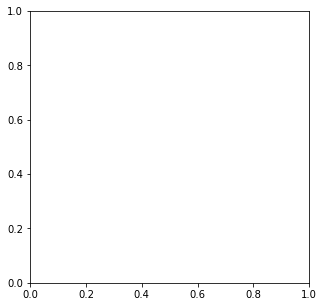

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[:, -2].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# # Set the axis labels with bold font weight
# ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
# ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# # Set the title with bold font weight
# ax.set_title(r"${t = 0.98}$", fontsize=26, color='black', fontweight='bold')

# # Set the number of ticks for x-axis and y-axis to 3
# ax.set_xticks([-1, 0, 1])
# ax.set_yticks([-1, 0, 1])

# # Set tick labels fontweight to bold and increase font size
# ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # # Set the fontweight for tick labels to bold
# # for tick in ax.get_xticklabels() + ax.get_yticklabels():
# #     tick.set_weight('bold')

# # Set the spines linewidth to bold
# ax.spines['top'].set_linewidth(2)
# ax.spines['right'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)

# # Set the legend
# # ax.legend()

# plt.savefig('LEM_0.98_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### Contour plot where 80 percent for PINN solution and 20 percent for lem solution

### Exact contour

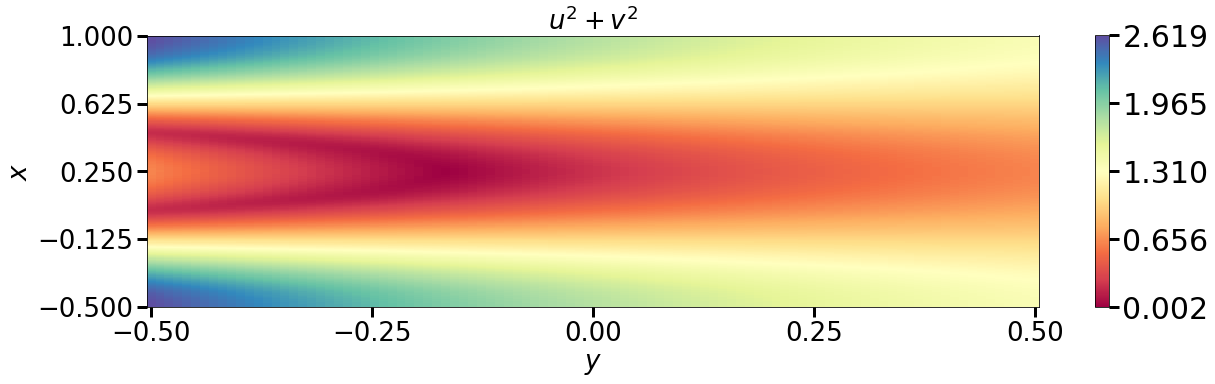

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = vel.T

# Define custom color levels
x = np.linspace(-0.5, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(-0.5, 0.5, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
# x = np.linspace(-0.5, 1, 100)
# y = np.linspace(-0.5, 0.5, 256)
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
# print(T.shape)
# print(X.shape)
# print(concatenated_array.shape)
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='Spectral')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$y$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u^2+v^2$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_exact_NS.pdf', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


In [57]:
concatenated_array.shape

(100, 256)

In [60]:
vel.shape

(256, 100)

In [59]:
# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()
print(concatenated_array.shape)

(100, 256)


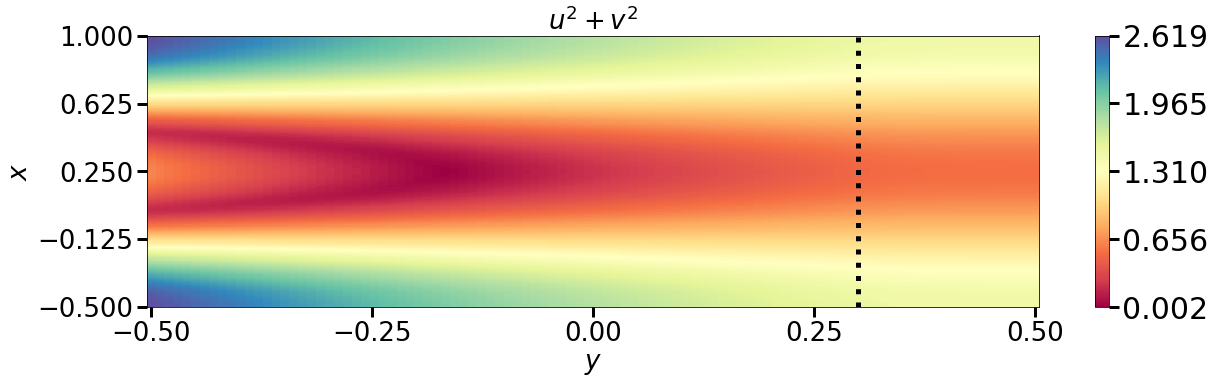

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()


# Define custom color levels
x = np.linspace(-0.5, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(-0.5, 0.5, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
# print(T.shape)
# print(X.shape)
# print(concatenated_array.shape)
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='Spectral')


# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$y$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u^2+v^2$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.3, color='black', linestyle='dotted', linewidth=5)

# #plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20_NS.pdf', dpi=500, bbox_inches="tight")
# # Show the plot
# plt.show()
